In [2]:
import scipy
import pandas as pd
import h5py
import SimpleITK as sitk
import os
join = os.path.join
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import json
import nibabel as nib
from skimage import measure
import json

In [4]:
h5_path = "/data3/home/lishengyong/data/ssc_3d/h5_files"
for filepath in Path(h5_path).iterdir():
    with h5py.File(filepath) as file:
        for key in file.keys():
            print(key)

centers
datas
lung_masks
masks
names
spacings
centers
datas
lung_masks
masks
names
spacings
centers
datas
lung_masks
masks
names
spacings
centers
datas
lung_masks
masks
names
spacings
centers
datas
lung_masks
masks
names
spacings


In [2]:

def translate(image, translation, padding):
    target = np.copy(image)
    if len(image.shape) == 3:
        x, y, z = translation
    else:
        x, y = translation
    if x > 0:
        target[x:] = target[:-x]
        target[:x] = padding
    elif x < 0:
        target[:x] = target[-x:]
        target[x:] = padding
    if y > 0:
        target[:, y:] = target[:, :-y]
        target[:, :y] = padding
    elif y < 0:
        target[:, :y] = target[:, -y:]
        target[:, y:] = padding

    if len(image.shape) == 3:
        if z > 0:
            target[:, :, z:] = target[:, :, :-z]
            target[:, :, :z] = padding
        elif z < 0:
            target[:, :, :z] = target[:, :, -z:]
            target[:, :, z:] = padding
    return target

def resize_image(image2D, new_size, padding):
    # try:
    #     if is_number(new_size):
    #         new_size = [new_size] * 2
    # except:
    #     pass

    if (image2D.shape[0] == new_size[0] and image2D.shape[1] == new_size[1]):
        return image2D

    if (image2D.shape[0] > new_size[0]):
        start = (image2D.shape[0] - new_size[0]) // 2
        image2D = image2D[start:start + new_size[0]]
    if (image2D.shape[1] > new_size[1]):
        start = (image2D.shape[1] - new_size[1]) // 2
        image2D = image2D[:, start:start + new_size[1]]

    new_img = np.zeros(new_size)
    new_img[:, :] = padding
    original_shape = image2D.shape

    offset = (new_size[0] - original_shape[0])
    left = int(np.round(offset / 2 + 1e-10))
    right = int(new_size[0] - (offset - left))

    offset = (new_size[1] - original_shape[1])
    upper = int(np.round(offset / 2 + 1e-10))
    lower = int(new_size[1] - (offset - upper))

    new_img[left:right, upper:lower] = image2D
    return new_img

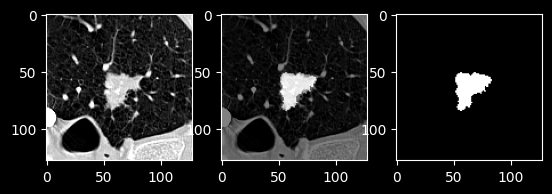

In [40]:
s_index, e_index = 0, 10
import matplotlib.pyplot as plt

for i in range(s_index, e_index):
    _img = img[i][..., 32]
    _img = (np.clip(_img, a_max=300, a_min=-1000) + 1000)/(1000+300)
    _mask = roi_arr[i*9:(i*9 + 8)]
    
    _m_c = np.around(scipy.ndimage.center_of_mass(_mask)).astype(int)
    _mask = _mask[_m_c[0]]
    cube_c = np.array(_mask.shape)//2
    _mask = translate(_mask, np.array(cube_c - _m_c[1:]), padding=0)
    #print(_mask.shape, _img.shape)
    _mask = resize_image(_mask, new_size=_img.shape, padding=0)
    #print(measure.regionprops(_mask.astype(int))[0].centroid)
    plt.subplot(1,3,1).imshow(_img, cmap='gray')
    plt.subplot(1,3,2).imshow(_img + _mask, cmap='gray')
    plt.subplot(1,3,3).imshow(_mask, cmap='gray')

In [57]:
def get_mask(roi_arr, i):
    # 给一个index，获取对应的mask
    gt_mask = roi_arr[i * 9: (i*9 + 8)]
    if np.sum(gt_mask) == 0:
        return np.zeros((128, 128))
    center = np.around(scipy.ndimage.measurements.center_of_mass(gt_mask)).astype(int)
    gt_mask_2d = gt_mask[center[0]]
    
    cube_center = np.array(gt_mask_2d.shape)//2
    gt_mask_2d = translate(gt_mask_2d, np.array(cube_center - center[1:]), padding=0)
    gt_mask_2d = resize_image(gt_mask_2d, new_size=(128, 128), padding=0)
    gt_mask_2d = np.flip(np.rot90(gt_mask_2d), axis=0)
    return gt_mask_2d

def get_2d_mask(roi_arr, i):
    # 给一个index，获取对应的mask
    gt_mask_2d = roi_arr[i]
    if np.sum(gt_mask_2d) == 0:
        return np.zeros((128, 128))
    center = np.around(scipy.ndimage.measurements.center_of_mass(gt_mask_2d)).astype(int)
    cube_center = np.array(gt_mask_2d.shape)//2
    gt_mask_2d = translate(gt_mask_2d, np.array(cube_center - center), padding=0)
    gt_mask_2d = resize_image(gt_mask_2d, new_size=(128, 128), padding=0)
    gt_mask_2d = np.flip(np.rot90(gt_mask_2d), axis=0)
    return gt_mask_2d
    

In [58]:
# mapping
file_path = "/data3/home/lishengyong/data/ssc_0802/h5.files/lidc.bad.mask.size.after.adjust.h5"
def file_mapping(file_path, is_2d):
    with h5py.File(file_path, 'r') as f: #打开h5文件
    # 创建h5文件names和centers字段的df
        f_dict = {}
        f_dict["centers"] = [str(i).replace(" ", ",").replace(",,",",")[1:-1].strip(",") for i in f["centers"]]
        f_dict["names"] = f["names"]
        h5_df = pd.DataFrame.from_dict(f_dict)
        # 创建name+center字段用于merge
        h5_df["names+centers"] = [str(i[0])[2:-1]+"+"+str(j).replace(",,",",") for i, j in zip(h5_df["names"], h5_df["centers"])]
        # 读取pred表格
        pred_path = file_path.replace("h5", "pred")
        nii_df = pd.read_csv(pred_path, sep="\t", header=None).iloc[:, [0, 3]]
        nii_df.columns = ["names", "centers"]
        nii_df["nii_index"] = range(len(nii_df))
        nii_df["names+centers"] = [os.path.basename(i).replace("npz", "zarr")+"+"+str(j) for i, j in zip(nii_df["names"], nii_df["centers"])]
        nii_df.drop_duplicates(subset=['names+centers'],keep='first',inplace=True)
        # 合并的时候应该以h5文件为主
        index_df = pd.merge(h5_df, nii_df, how="left", on=["names+centers"])
        # 读取nii文件
        mask = sitk.ReadImage(file_path.replace("h5", "nii.gz"))
        mask_array = sitk.GetArrayFromImage(mask)
        mask_list = [-1] * len(h5_df)
        for i, j in enumerate(index_df["nii_index"]):
            if not pd.isna(j):
                if is_2d:
                    mask_list[i] = get_2d_mask(mask_array, j)
                else:
                    mask_list[i] = get_mask(mask_array, j)
            else:
                print(i)

        # 保存文件
        index_df.to_csv(file_path.replace("h5.files", "pred.files/processed_csv").replace("pred.h5", "csv"))
        store_path = file_path.replace("h5.files", "h5.files/processed_h5")
        print(store_path)
        with h5py.File(store_path, "w") as new_f:
            gts = np.array(mask_list)
            print(gts.shape)
            new_f["gts"] = gts
            for key in f.keys():
                new_f[key] = f[key][:]
    print("set one")
#file_mapping(file_path)

In [ ]:
import matplotlib.pyplot as plt
import h5py
from pathlib import Path
import numpy as  np
cases = [i for i in Path("/data3/home/lishengyong/data/ssc_0802/h5.files/processed_h5").iterdir()]
print(cases[5].name)
with h5py.File(cases[5], "r") as f:
    size = f["datas"][:].shape[-1]
    print(size)
    for i in range(1000):
        _img = f["datas"][i][..., size // 2]
        _img = (np.clip(_img, a_max=300, a_min=-1000) + 1000) / (1000+300)
        _mask = f["gts"][i]
        if np.sum(_mask) > 50:
            plt.subplot(1,3,1).imshow(_img, cmap='gray')
            plt.subplot(1,3,2).imshow(_img + _mask, cmap='gray')
            plt.subplot(1,3,3).imshow(_mask, cmap='gray')
            plt.show()

In [18]:
with h5py.File("/data3/home/lishengyong/data/ssc_0802/h5.files/processed_h5/lidc.bad.mask.size.after.adjust.h5", "r+") as f:
    data = f["gts"][:]
    data = np.transpose(data, (0,2,1))
    f["new_gts"] = data

In [68]:
cases = [i for i in Path("/data3/home/lishengyong/data/ssc_0802/h5.files").iterdir()]
for case in cases:
    print(case.name)
    if case.name == "lidc.center.nodule.after.adjust.h5":
        file_mapping(str(case), True)
    if case.name == "lung_false_positive_batch2.4_marker.1618.center.nodule.h5":
        file_mapping(str(case), True)
    if case.is_dir():
        continue
    # file_mapping(str(case), False)

processed_h5
lidc.bad.mask.size.after.adjust.h5
merged_large.bad.mask.size.after.adjust.h5
bm.size.bad.mask.size.after.adjust.h5
lidc.center.nodule.after.adjust.h5


/tmp/ipykernel_540061/3927294644.py:20: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  center = np.around(scipy.ndimage.measurements.center_of_mass(gt_mask_2d)).astype(int)


/data3/home/lishengyong/data/ssc_0802/h5.files/processed_h5/lidc.center.nodule.after.adjust.h5
(2414, 128, 128)
set one
lung_false_positive_batch2.big.than.8.after.adjust.h5
lung_false_positive_batch2.4_marker.1618.center.nodule.h5


/tmp/ipykernel_540061/3927294644.py:20: DeprecationWarning: Please use `center_of_mass` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  center = np.around(scipy.ndimage.measurements.center_of_mass(gt_mask_2d)).astype(int)


/data3/home/lishengyong/data/ssc_0802/h5.files/processed_h5/lung_false_positive_batch2.4_marker.1618.center.nodule.h5
(1618, 128, 128)
set one


In [ ]:
# 把h5文件切片
store_path = "/data3/home/lishengyong/data/ssc_0802/new_slices"
def write(a, path, spacing=None):
    b = sitk.GetImageFromArray(a)
    if spacing is not None:
        b.SetSpacing(spacing=spacing)
    sitk.WriteImage(b, path)
for i in ["images", "masks", "labels", "3D_images", "3D_masks"]:  #, "labels", "3D_images", "3D_masks"
    os.makedirs(os.path.join(store_path, i), exist_ok=True)
    
    
def section(i):    
    file = h5py.File(i, "r")
    k = 0
    for j in range(len(file["centers"])):
        if file["masks"][j].shape[2] == 64:
            max_index = 32
        elif file["masks"][j].shape[2] == 32:
            max_index = 16
        else:
            return False
        gt = file["new_gts"][j]
        if k < 50:
            _img = file["datas"][j][..., 32]
            _img = (np.clip(_img, a_max=300, a_min=-1000) + 1000) / (1000+300)
            plt.subplot(1,3,1).imshow(_img, cmap='gray')
            plt.subplot(1,3,2).imshow(_img + gt, cmap='gray')
            plt.subplot(1,3,3).imshow(gt, cmap='gray')
            plt.show()
            k += 1
        mask = file["masks"][j,...,max_index]
        single_store = store_path + f"/images/{str(file['names'][j])[2:-1]}_{file['centers'][j]}.nii.gz"
        # if any((np.sum(gt) == 0, np.sum(gt) > 9000, np.sum(mask) == 0)):
        #     continue
        if np.sum(mask) == 0 or np.sum(gt) == 0:
            continue
        # elif os.path.exists(single_store):
        #     continue
        write(mask, single_store.replace("slices/images", "slices/masks"))
        write(gt, single_store.replace("slices/images", "slices/labels"))
        data_3D = file["datas"][j, ..., max_index-16:max_index+16]
        Mask_3D = file["masks"][j, ..., max_index-16:max_index+16]
        write(Mask_3D, single_store.replace("slices/images", "slices/3D_masks"))
        write(data_3D, single_store.replace("slices/images", "slices/3D_images"))
        write(file["datas"][j,...,max_index], single_store)
        
#for i in Path("/data3/home/lishengyong/data/ssc_0802/h5.files/processed_h5").iterdir():
# section("/data3/home/lishengyong/data/ssc_0802/h5.files/processed_h5/lidc.bad.mask.size.after.adjust.h5")

In [10]:
store_path = "/data3/home/lishengyong/data/ssc_3d/slices"
for i in ["3D_images", "3D_masks"]:
    os.makedirs(os.path.join(store_path, i), exist_ok=True)
def write(a, path, spacing=None):
    b = sitk.GetImageFromArray(a)
    if spacing is not None:
        spacing = spacing.tolist()
        b.SetSpacing(spacing=spacing)
    sitk.WriteImage(b, path)
    
def section(store_path, h5path):    
    with h5py.File(h5path, "r") as file:
        for j in range(len(file["centers"])):
            single_store = store_path + f"/3D_images/{file['names'][j][0].decode('utf-8')}_{file['centers'][j]}.nii.gz"
            data_3D = file["datas"][j, 32:160, 32:160, :]
            Mask_3D = file["masks"][j, 32:160, 32:160, :]
            Mask_3D[Mask_3D != 1] = 0
            write(Mask_3D, single_store.replace("3D_images", "3D_masks"), file["spacings"][j])
            write(data_3D, single_store, file["spacings"][j])
            
for i in Path(h5_path).iterdir():
    if i.name == "lung_false_positive_batch2.4_marker_2021.0422.0623_tp.train.fix_bug_2022.9.22.coord.v89.pred.h5":
        section(store_path, i)
    if i.name == "nodules.list.rj.20230703.coord.v89.pred.h5":
        section(store_path, i)

In [10]:
d = dict()
a = os.listdir("/data3/home/lishengyong/data/ssc_3d/slices/infer_3d_iter/axis_1/0818_98/iter8/embadding")
slice_store_path = "/data3/home/lishengyong/data/ssc_3d/slices"
k = 0
for i in Path("/data3/home/lishengyong/data/ssc_3d/h5_files").iterdir():
    if i.name != "bm_human.tp.coord.v89.pred.h5":
        continue
    print(i.name)
    names = []
    with h5py.File(i) as file:
        for j in range(len(file["centers"])):
            name = f"{file['names'][j][0].decode('utf-8')}_{file['centers'][j]}"
            names.append(name)
    cases = set(names).difference(set(a))
    print(len(cases), len(names))
    with open(os.path.join(slice_store_path, "bm_human_queshi.json"), "w") as f:
        json.dump(list(cases), f)
     

bm_human.tp.coord.v89.pred.h5
688 1538


: 

In [21]:
with open(os.path.join(slice_store_path, "lndb_weight.json"), "r") as f:
    cases = json.load(f)
show_case = []
for case in cases:
    path = join("/data3/home/lishengyong/data/ssc_3d/slices/infer_3d_iter/axis_1/0818_98/iter8/embadding", case)
    if len(os.listdir(path)) > 100:
        show_case.append(case)

print(show_case[3:6])

['015.zarr_[367 309 304]', '015.zarr_[367 309 304]', '056.zarr_[324 326 260]']


In [8]:
for key, value in d.items():
    d[key] = value.tolist()          
with open("/data3/home/lishengyong/data/ssc_3d/slices/ssc_spacing.json", mode="w") as file:
    json.dump(d, file)                

In [6]:
# set spacing
def set_spacing(path, spacing):
    image = sitk.ReadImage(path)
    image.SetSpacing(spacing)
    #sitk.WriteImage(image, path)
for filepath in Path("/data3/home/lishengyong/data/ssc_0802/h5.files/processed_h5").iterdir():
    with h5py.File(filepath, "r") as file:
        for j in range(file['names'][:].shape[-1]):
            single_store = f"/data3/home/lishengyong/data/ssc_0802/new_slices/3D_images/{str(file['names'][j])[2:-1]}_{file['centers'][j]}.nii.gz"
            if os.path.exists(single_store):
                set_spacing(single_store, file['new_spacings'][j])
                set_spacing(single_store.replace("images", "masks"), file['new_spacings'][j])
            
            

In [55]:
k = 1
for filepath in Path("/data3/home/lishengyong/data/ssc_0802/slices/labels").iterdir():
    gt = nib.load(filepath)
    gt_arr = gt.get_fdata()
    mask = nib.load(str(filepath).replace("label", "old_mask"))
    mask_arr = mask.get_fdata()

    new_mask = np.zeros((128, 128))
    gt_labeled = measure.label(gt_arr).astype(float)
    nib.save(nib.Nifti1Image(gt_labeled, None), str(filepath).replace("label", "labeled_label"))

    gt_ccs = measure.regionprops(gt_labeled)
    for cc in gt_ccs:
        labels = mask_arr[tuple(cc.coords.T)]
        if labels.sum() == 0:
            mask_arr[tuple(cc.coords.T)] = 1
    
    ccs = measure.regionprops(measure.label(mask_arr))
    if len(ccs) > 1:
        for cc in ccs:
            # 找到gt对应的label
            labels = gt_labeled[tuple(cc.coords.T)] 
            if labels.sum() == 0:
                label = 0
            else:
                labels = labels[labels != 0]
                counts = np.bincount(labels.astype(int))
                label = np.argmax(counts)
                
            new_mask[tuple(cc.coords.T)] = label
            
    else:
        new_mask = mask_arr
    assert np.unique(new_mask).all() == np.unique(gt_labeled).all(), "wrong"
    labeled_mask = nib.Nifti1Image(new_mask, None)
    nib.save(labeled_mask, str(filepath).replace("label", "mask"))
    
        # if len(np.unique(mask_arr)) > 10:
            
        #     print(filepath.name)
        #     plt.subplot(131).imshow(gt_labeled, cmap='tab20')
        #     plt.subplot(132).imshow(mask_arr)
        #     plt.subplot(133).imshow(new_mask, cmap='tab20')
        #     plt.show()
        #     k += 1
    

In [67]:
old_root = "/data3/home/lishengyong/data/ssc_0802/slices"
new_root = "/data3/home/lishengyong/data/ssc_0802/new_slices"
os.makedirs(join(new_root, "masks"), exist_ok=True)
os.makedirs(join(new_root, "labels"), exist_ok=True)


for label_path in Path(join(old_root, "labeled_labels")).iterdir():
    roi = nib.load(label_path)
    roi_arr = roi.get_fdata()
    mask_path = str(label_path).replace("labeled_label", "mask")
    mask = nib.load(mask_path)
    mask_arr = mask.get_fdata()
    for i in range(1, int(np.max(roi_arr)) + 1):
        new_roi = np.zeros((128, 128))
        new_roi[roi_arr == i] = 1
        new_mask = np.zeros((128, 128))
        new_mask[mask_arr == i] = 1
        new_mask_path = mask_path.replace("slice", "new_slice").replace("labeled_", "")
        new_mask_path = new_mask_path[:-7] + f"_{i}.nii.gz" 
        new_label_path = str(label_path).replace("slice", "new_slice").replace("labeled_", "")
        new_label_path = new_label_path[:-7] + f"_{i}.nii.gz" 
        #nib.save(nib.Nifti1Image(new_mask, None), new_mask_path)
        nib.save(nib.Nifti1Image(new_roi, None), new_label_path)
        

In [65]:
with open(join(old_root, "dataset.json")) as file:
    data = json.load(file)

new_train, new_val, new_test = [], [], []
for i in data["train"]:
    for label in range(1, 16):
        if os.path.exists(i["label"].replace(".nii", f"_{label}.nii")):
            new_train.append(
                {"image": i["image"],
                 "mask": i["mask"].replace(".nii", f"_{label}.nii"),
                 "label": i["label"].replace(".nii", f"_{label}.nii")}
            )
        else:
            break

for i in data["validation"]:
    for label in range(1, 16):
        if os.path.exists(i["label"].replace(".nii", f"_{label}.nii")):
            new_val.append(
                {"image": i["image"],
                 "mask": i["mask"].replace(".nii", f"_{label}.nii"),
                 "label": i["label"].replace(".nii", f"_{label}.nii")}
            )
        else:
            break
        
for i in data["test"]:
    for label in range(1, 16):
        if os.path.exists(i["label"].replace(".nii", f"_{label}.nii")):
            new_test.append(
                {"image": i["image"],
                 "mask": i["mask"].replace(".nii", f"_{label}.nii"),
                 "label": i["label"].replace(".nii", f"_{label}.nii")}
            )
        else:
            break

print(len(new_train), len(new_val), len(new_test))
new_data = {"train": new_train, "validation":new_val, "test":new_test} #"train": train_list, "validation":val_list, 
d = json.dumps(new_data)
with open(new_root+"/dataset.json", "w") as f:
    f.write(d)

4586 1577 1580


In [7]:
# chaifen nii
img = nib.load("/data2/home/zoulongkuan/lung_nodule/ssc/nii.gz.files/\
lung_false_positive_batch2.4_marker_2021.0422.0623_tp.train.fix_bug\
_2022.9.22.4nodule.size.txt.h5.data.nii.gz").get_fdata()
mask = nib.load("/data2/home/zoulongkuan/lung_nodule/ssc/nii.gz.files/\
lung_false_positive_batch2.4_marker_2021.0422.0623_tp.train.fix_bug\
_2022.9.22.4nodule.size.txt.h5.data.refine.mask.nii.gz").get_fdata()
print(img.shape)
print(mask.shape)


(256, 256, 15346)
(256, 256, 15346)


In [8]:
store_path = "/data3/home/lishengyong/data/ssc_0802/new821"
for i in ["images", "masks"]:
    os.makedirs(join(store_path, i), exist_ok=True)
for i in range(img.shape[-1]):
    slice_img = nib.Nifti1Image(img[:,:,i], None)
    slice_mask = nib.Nifti1Image(mask[:,:,i], None)
    nib.save(slice_img, join(store_path, "images", f"{i}.nii.gz"))
    nib.save(slice_mask, join(store_path, "masks", f"{i}.nii.gz"))

In [14]:
#叠起来
from tqdm import tqdm
pred_path = f"/data3/home/lishengyong/data/ssc_0802/new821/infer1/0818_98_processed"
imgs = []
for i in tqdm(range(15346)):
    img = nib.load(join(pred_path, f"{i}.nii.gz")).get_fdata()
    img[img == 1] = 0
    img[img == 2] = 1
    imgs.append(img)
all_image = np.stack(imgs, axis=2)
nib.save(nib.Nifti1Image(all_image, None), "/data3/home/lishengyong/data/ssc_0802/new821/infer1/kendingdui.nii.gz")
    

100%|██████████| 15346/15346 [00:31<00:00, 486.59it/s]


In [6]:
# 叠回去
pred_path = "/data3/home/lishengyong/data/ssc_3d/slices/infer_3d_iter/axis_1/0818_98/iter9/opening"
store_path = "/data3/home/lishengyong/data/ssc_3d/slices/infer_3d_iter"
preds = []
with open("/data3/home/lishengyong/data/ssc_3d/slices/lndb_weight.json", "r") as json_file:
    cases = json.load(json_file)
for case in cases:
    case = case+".nii.gz"
    pred = nib.load(join(pred_path, case))
    pred_arr = pred.get_fdata()
    pred_arr = np.transpose(pred_arr, (2,1,0))
    pred_arr = np.pad(pred_arr, ((32,32), (32,32), (0,0)), mode="constant", constant_values=0)
    if np.max(pred_arr) == 0:
        print(case)
    preds.append(pred_arr)

pred_img = nib.Nifti1Image(np.stack(preds), None)


In [7]:
nib.save(pred_img, join(store_path, "lndb_weight_1.coord.v89.pred.nii.gz"))

    
        